In [1]:
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as stats

import scipy.special as sp
import math
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
rng = np.random.default_rng(0)

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d)"""


def logp(x):
    return -0.5 * np.dot(x, x)


def grad_logp(x):
    return -x


def logp_laplace(x, scale=1):
    return -np.sum(np.abs(x)) / scale

def grad_logp_laplace(x, scale=1):
    return -np.sign(x) / scale

In [3]:
"""Посчитаем ESS через интегрированную автокорреляции"""


def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode="full")
    acf = acf[len(acf) // 2 :]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [4]:
"""Базовая реализация MH алгоритма"""


def mh(u, du, x0, steps, mh_scale, burn, **kwargs):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, mh_scale, size=d)

        if np.log(rng.uniform()) < (u(prop) - u(x)):
            x = prop
            accept += 1

        chain[t] = x

    return chain[burn:], accept / steps

In [5]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

# def mala(x0, steps, step):

#     Z = np.random.normal(0, 1, steps)
#     x = x0.copy()
#     d = len(x)
#     u = logp
#     du = grad_logp

#     chain = np.zeros((steps, d))
#     accept = 0
#     chain[0] = x

#     gamma = step


#     for n in range(steps - 1):
#         yn = chain[n] - gamma * du(chain[n]) + np.sqrt(2 * gamma) * Z[n + 1]
#         prop = (
#             chain[n] + (yn - chain[n]) * np.eye(d) - (u(chain[n]) - alpha(chain[n], yn))
#         )

#         if np.log(rng.uniform()) < (logp(prop) - logp(x)):
#             accept += 1
#             x = prop
#         chain[n + 1] = x  # chain[n]

#     return chain, accept / steps


def mala(u, du, x0, steps, mala_step, burn, **kwargs):
    def q(a, b):
        return rng.normal(a, b, 2)

    Z = np.random.normal(0, 1, len(x0))

    x = x0.copy()
    d = len(x)
    #u = logp
    #du = grad_logp

    chain = np.zeros((steps, d))
    accept = 0
    chain[0] = x

    gamma = mala_step

    for n in range(steps - 1):
        prop = chain[n] + gamma * du(chain[n]) + np.sqrt(2 * gamma) * np.random.normal(0, 1, d)
        if np.log(np.random.uniform(0, 1)) < (u(prop) / u(x)):
            accept += 1
            x = prop
            
        chain[n + 1] = x  # chain[n]
    return chain[burn:], accept / steps

In [6]:
def get_hist(data, bins, norm=True):
    hist = np.histogram(data, bins=bins, density=True)
    edges = []
    for i in range(len(hist[0])):
        edges.append((hist[1][i] + hist[1][i + 1]) / 2)
    if norm:
        return edges, hist[0]
    return edges, hist[0]


def do_expirement(target_func, u, du, **config):
    # bins = 30

    # d = 10
    # steps = 50000
    # burn = 5000

    d =config['d']
    bins=config['bins']
    dim=config['dim']
    print(config)

    x0 = np.ones(d) * 3  # стартанев в точке 3 например

    mh_chain, mh_acc = mh(u, du, x0, **config)
    mala_chain, mala_acc = mala(u, du, x0, **config)


    mh_data = mh_chain[:, dim]
    mala_data = mala_chain[:, dim]
    



    mh_ess = ess(mh_data)
    mala_ess = ess(mala_data)

    
    info_str = [
        f"Acceptance rate:",
        f"MH:   {mh_acc}",
        f"MALA: {mala_acc}",
        "",
        "ESS:",
        f"MH:   {mh_ess:.2f}",
        f"MALA: {mala_ess:.2f}",
        "",
        "Config:"
    ]
    max_len = max(map(lambda x: len(x), config))
    
    for key in config:
        value = config[key]
        info_str.append(f'{key}:{" " * (max_len - len(key))} {str(value)}')



    target = target_func(bins)

    fig = plt.figure(figsize=(25, 30))

    ax1 = fig.add_subplot(3, 1, 1)      # initialize the top Axes
    ax1.plot(*get_hist(mala_data, bins), label="MALA")
    ax1.plot(*get_hist(mh_data, bins), label="MH")
    ax1.plot(target[0], target[1], label="target")
    ax1.text(-3.5, 0.1, "\n".join(info_str), fontfamily="monospace")

    # Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
    # график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)

    ax2 = fig.add_subplot(3,2,3)
    ax2.plot(mh_data, label="MH chain")
    ax3 = fig.add_subplot(3,2,4)
    ax3.plot(mala_data, label="MALA chain")

    
    ax4 = fig.add_subplot(3,2,5)
    ax5 = fig.add_subplot(3,2,6)
    plot_acf(mh_data, ax=ax4, lags=10000)
    plot_acf(mala_data, ax=ax5, lags=10000);

    # https://github.com/statsmodels/statsmodels/issues/4155



    for ax in fig.axes:
        ax.legend()
    # print(ess(mh_data), ess(mala_data))
    return mala_data, mh_data

cfg = {
    'bins': 40,
    'd': 10,
    'dim': 0,
    'steps': 50000,
    'burn': 5000,
    'mala_step': 0.02,
    'mh_scale': 0.15
}
def target_gaussian(bins):
    mu = 0
    variance = 1
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, bins)
    y = stats.norm.pdf(x, mu, sigma)
    return x, y

def target_laplace(bins):
    loc = 0
    scale = 1
    x = np.linspace(loc - 5 * scale, loc + 5 * scale, bins)
    y = stats.laplace.pdf(x, loc=loc, scale=scale)
    
    return x, y


# plt.plot(xs, ys)
# Выведите снизу acceptance rate и медианный ESS по размерности d для MH и MALA. Не забудьте обрезать burn-in!
# ...

{'bins': 40, 'd': 10, 'dim': 0, 'steps': 50000, 'burn': 5000, 'mala_step': 0.02, 'mh_scale': 0.15}
{'bins': 40, 'd': 10, 'dim': 0, 'steps': 50000, 'burn': 5000, 'mala_step': 0.02, 'mh_scale': 0.15}


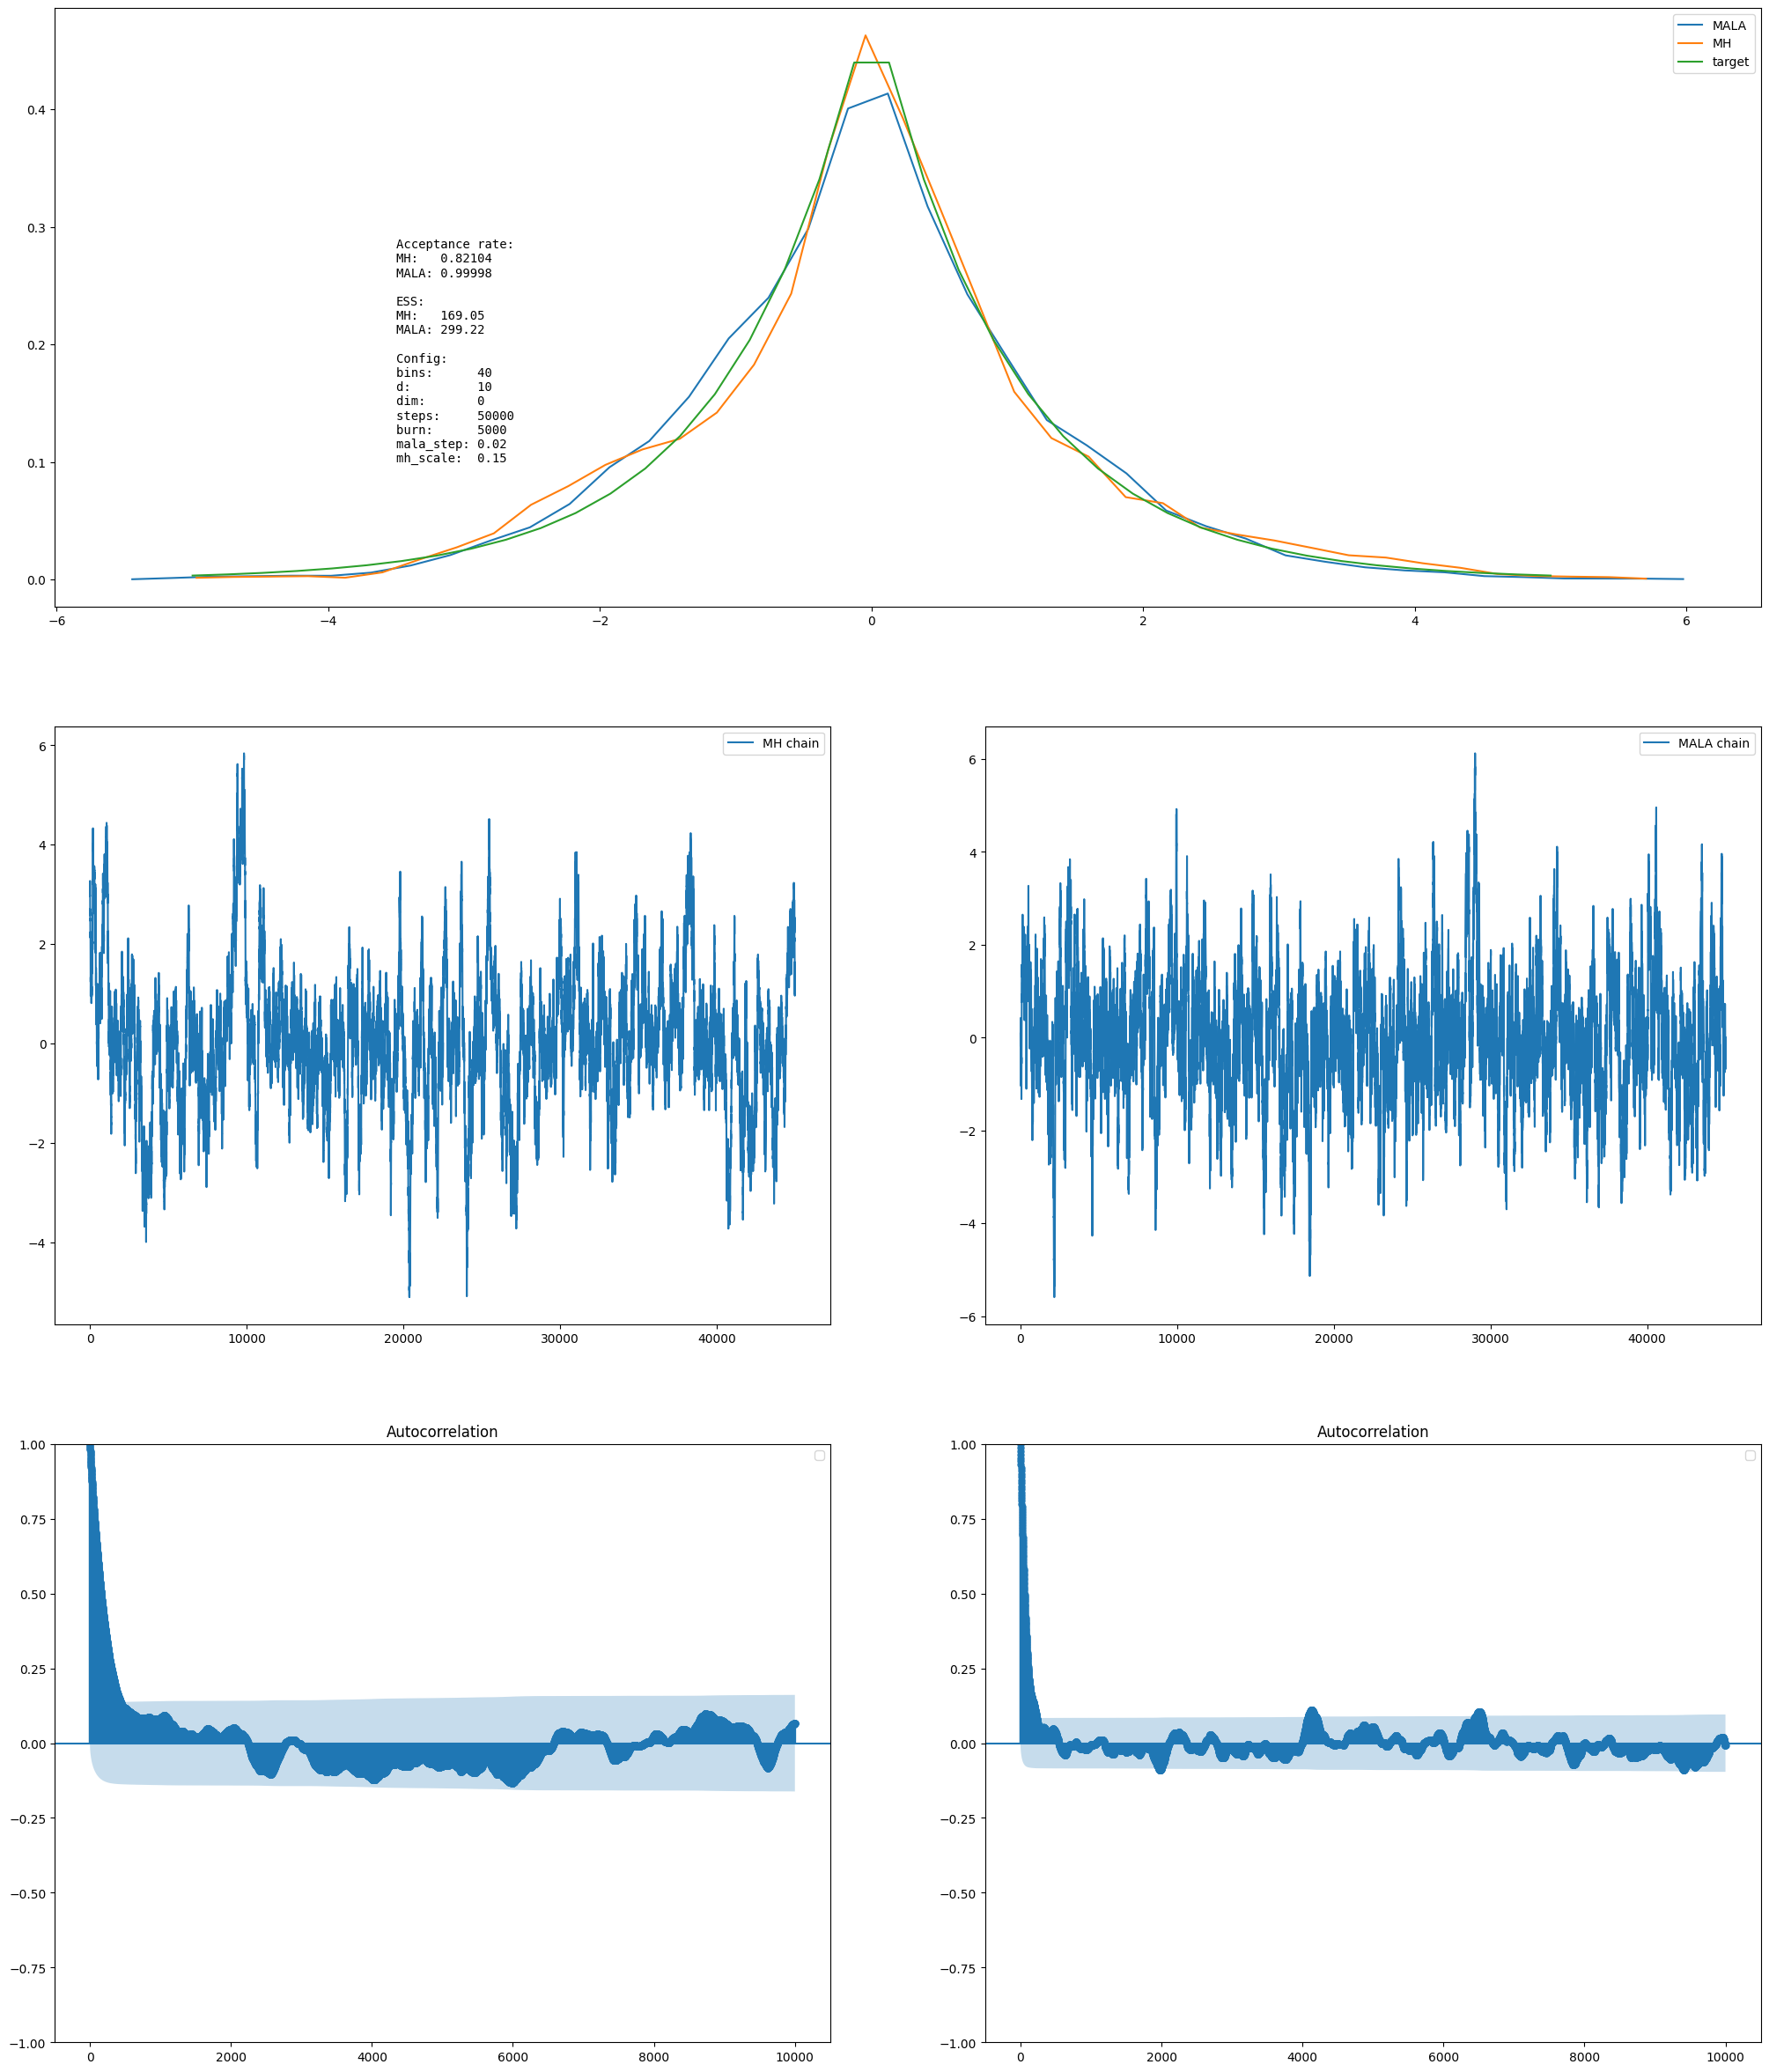

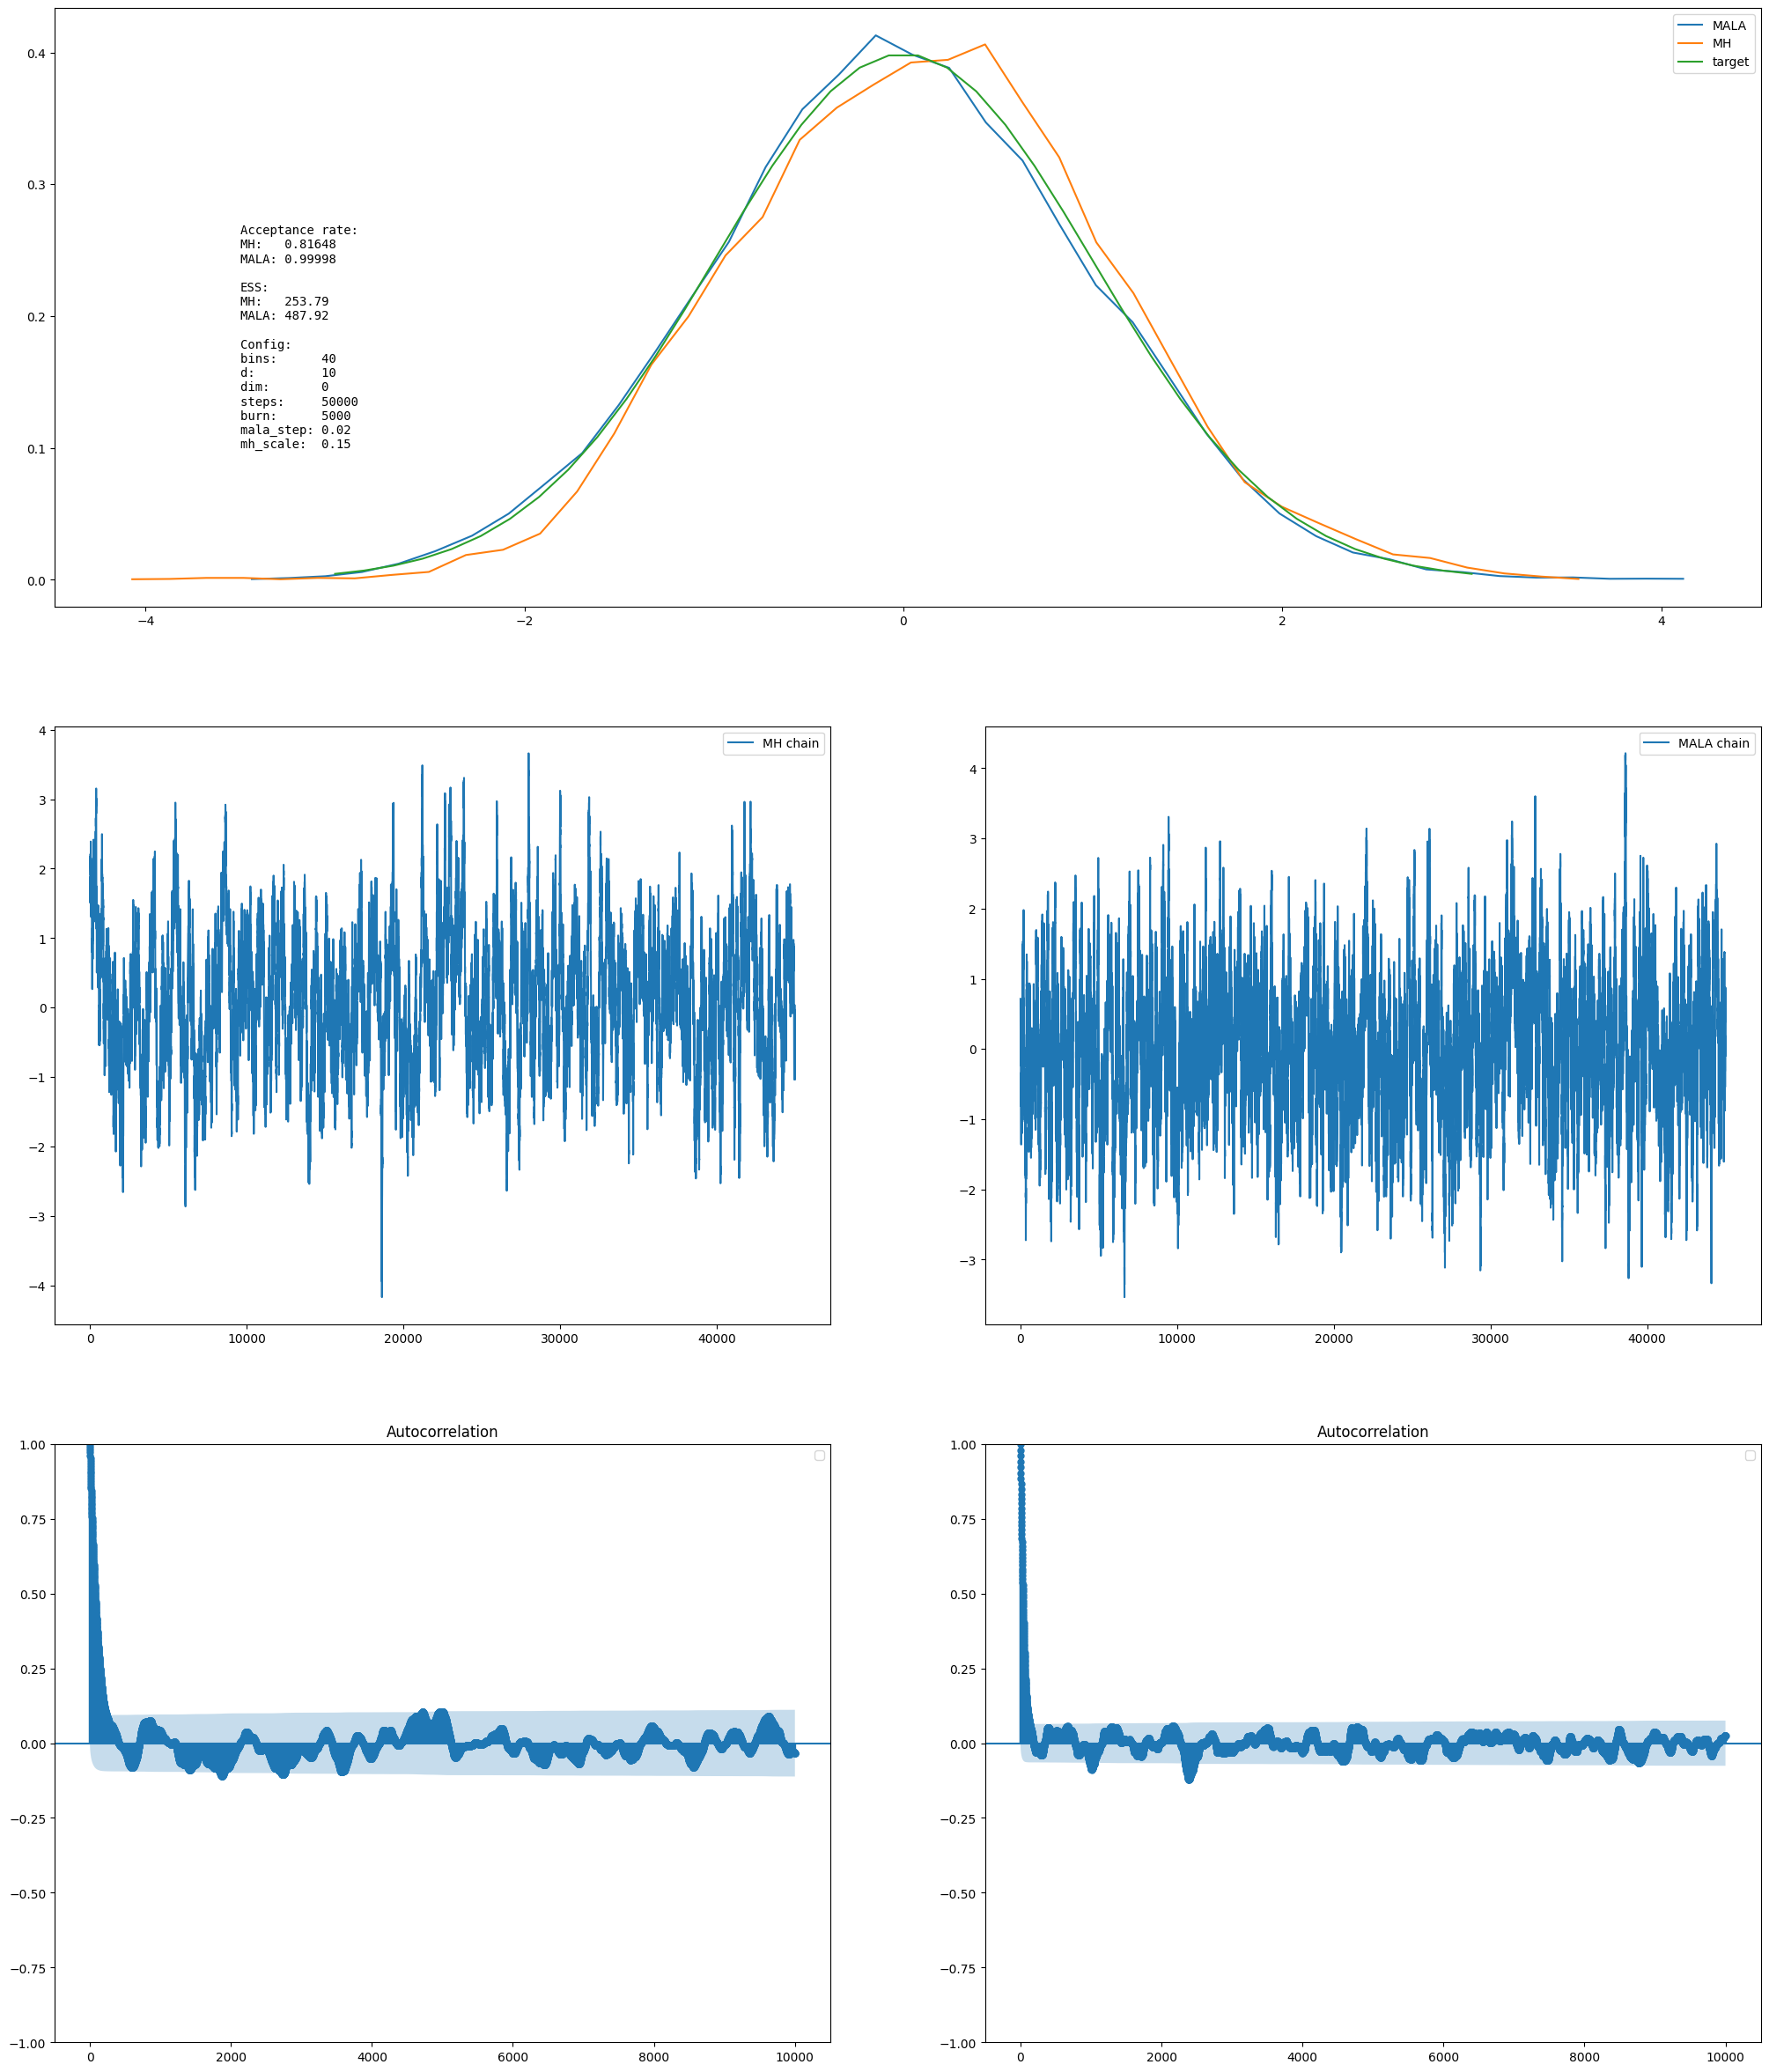

In [7]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)




mala_data, mh_data = do_expirement(target_laplace, logp_laplace, grad_logp_laplace, **cfg)
mala_data, mh_data = do_expirement(target_gaussian, logp, grad_logp, **cfg)